**IMPORTS**

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.utils as skl
from scipy.special import expit
from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import plotly.express as px
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

**MLP CLASS**

In [170]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        # Inicialização dos pesos e bias
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_output = np.zeros((1, output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def softmax_derivative(self, x):
        return x * (1 - x)

    def forward(self, X):
        # Camada oculta
        self.hidden_layer_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.tanh(self.hidden_layer_input)

        # Camada de saída
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        self.output_layer_output = self.softmax(self.output_layer_input)

        return self.output_layer_output

    def backward(self, X, y, learning_rate):
        # Calcula o erro
        output_error = y - self.output_layer_output

        # Atualiza os pesos da camada de saída
        output_delta = output_error * self.softmax_derivative(self.output_layer_output)
        self.weights_hidden_output += np.dot(self.hidden_layer_output.T, output_delta) * learning_rate
        self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate

        # Calcula o erro na camada oculta
        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)

        # Atualiza os pesos da camada oculta
        hidden_delta = hidden_error * self.tanh_derivative(self.hidden_layer_output)
        self.weights_input_hidden += np.dot(X.T, hidden_delta) * learning_rate
        self.bias_hidden += np.sum(hidden_delta, axis=0, keepdims=True) * learning_rate

    def calculate_metrics(self, y_true, y_pred):
        correct = np.sum(y_true == y_pred)
        total = len(y_true)

        accuracy = (correct / total)*100

        true_positive = np.sum((y_true == 1) & (y_pred == 1))
        false_positive = np.sum((y_true == 0) & (y_pred == 1))
        false_negative = np.sum((y_true == 1) & (y_pred == 0))

        precision = (true_positive / (true_positive + false_positive))*100 if (true_positive + false_positive) != 0 else 0
        recall = (true_positive / (true_positive + false_negative))*100 if (true_positive + false_negative) != 0 else 0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        return accuracy, precision, recall, f1

    def train(self, X, y, epochs, learning_rate):
        # Converta y para um array 2D se necessário
        if isinstance(y, pd.Series):
            y = pd.get_dummies(y).values

        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)

            # Backward pass
            self.backward(X, y, learning_rate)

            # Calcula as métricas de avaliação
            y_pred = np.argmax(output, axis=1)
            y_true = np.argmax(y, axis=1)
            acuracia, precisao, recall, f1 = self.calculate_metrics(y_true, y_pred)

            # Mostra as métricas a cada 10 epochs
            if epoch % 10 == 0:
                loss = -np.sum(y * np.log(output + 1e-8))  # constante para evitar log(0)
                print(f'\nÉpoca {epoch}, \nLoss: {loss}, \nAcurácia: {acuracia}, \nPrecisão: {precisao}, \nRecall: {recall}, \nF1-Score: {f1}\n')

    def predict(self, X):
        # Camada oculta
        hidden_layer_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        hidden_layer_output = self.tanh(hidden_layer_input)

        # Camada de saída
        output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_output) + self.bias_output
        output_layer_output = self.softmax(output_layer_input)

        return output_layer_output


    def evaluate(self, X_test, y_test):
        if isinstance(y_test, pd.Series):
            y_test = pd.get_dummies(y_test).values

        # Faça previsões nos dados de teste
        predictions = self.predict(X_test)

        # Converta as probabilidades em rótulos binários para as métricas de avaliação
        y_pred = np.argmax(predictions, axis=1)

        # Calcula as métricas de avaliação
        y_scores = predictions[:, 1]
        y_true = np.argmax(y_test, axis=1)
        accuracy, precision, recall, f1 = self.calculate_metrics(y_true, y_pred)
        auc = roc_auc_score(y_true, y_scores)

        print(f'Acurácia: {accuracy}, \nPrecisão: {precision}, \nRecall: {recall}, \nF1-Score: {f1}, \nAUC: {auc}')

        # Plota a matriz de confusão
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'])
        plt.title('Matriz de Confusão')
        plt.xlabel('Previsão')
        plt.ylabel('Verdadeiro')
        plt.show()


    def plot_decision_boundary(self, X, y):
        # Definir os limites do gráfico
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

        # Gerar grade de pontos
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                                np.arange(y_min, y_max, 0.1))

        # Previsões para cada ponto na grade
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)

        # Plotar a superfície de decisão
        plt.contourf(xx, yy, Z, alpha=0.8)

        # Plotar os pontos de dados
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='Set1')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xlabel('Feature1')
        plt.ylabel('Feature2')
        plt.title('Superfície de Decisão')
        plt.legend(loc='upper right')
        plt.show()

**DOWNLOAD REPOS**  

In [171]:
!mkdir -p local_datasets

!wget --quiet 'https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/__init__.py' -O 'local_datasets/__init__.py'

!wget --quiet 'https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/datasets-7627-10826-banana.csv' -O 'local_datasets/datasets-7627-10826-banana.csv'

!wget --quiet 'https://raw.githubusercontent.com/sauloafoliveira/cclw-mlm/master/local_datasets/rip.csv' -O 'local_datasets/rip.csv'

**LOAD DATASETS**

In [172]:
from local_datasets import load_banana, load_ripley, load_two_moon
ripley_data = load_ripley()
banana_data = load_banana()
two_moon_data = load_two_moon()

**EXIBIR DICIONÁRIOS - RIPLEY**

In [173]:
ripley_data


{'data': array([[ 0.05100797,  0.16086164],
        [-0.74807425,  0.08904024],
        [-0.77293371,  0.26317168],
        ...,
        [ 0.41851456,  1.04415721],
        [ 0.23231452,  0.81964284],
        [ 0.76204097,  0.57321846]]),
 'target': array([0, 0, 0, ..., 1, 1, 1])}

**EXIBIR DICIONÁRIOS - BANANA**

In [174]:
banana_data

{'data': array([[ 1.14 , -0.114],
        [-1.52 , -1.15 ],
        [-1.05 ,  0.72 ],
        ...,
        [ 2.64 ,  1.14 ],
        [ 0.769,  0.772],
        [-0.255, -0.142]]),
 'target': array([0, 1, 0, ..., 1, 0, 1])}

**EXIBIR DICIONÁRIOS - TWO_MOON**

In [175]:
two_moon_data

{'data': array([[ 6.32864057e-01,  7.74262931e-01],
        [ 1.97785439e+00,  2.90713597e-01],
        [ 1.99911102e+00,  4.57843468e-01],
        [ 1.96266956e+00,  2.29320619e-01],
        [ 9.28842104e-01,  3.70475838e-01],
        [-8.64263017e-01,  5.03040194e-01],
        [ 5.82656209e-01,  8.12718735e-01],
        [ 7.80891598e-01,  6.24666561e-01],
        [-2.80812862e-01,  9.59762542e-01],
        [-9.85807881e-01,  1.67877401e-01],
        [ 1.35736983e-01, -3.04019406e-03],
        [ 9.99111018e-01,  4.21565323e-02],
        [ 2.60515818e-01,  9.65469579e-01],
        [-9.20824925e-01,  3.89976226e-01],
        [-7.93887844e-01,  6.08064216e-01],
        [ 1.41921190e-02,  3.32122599e-01],
        [ 3.16214995e-02,  9.99499915e-01],
        [-3.40919189e-01,  9.40092605e-01],
        [ 9.68162303e-01,  2.50323301e-01],
        [ 4.95971445e-02,  1.88978438e-01],
        [ 8.06531175e-01,  5.91191562e-01],
        [ 3.18376970e-02,  2.49676699e-01],
        [ 6.00338051e-01

**MONTAGEM DO DATAFRAME - RIPLEY**

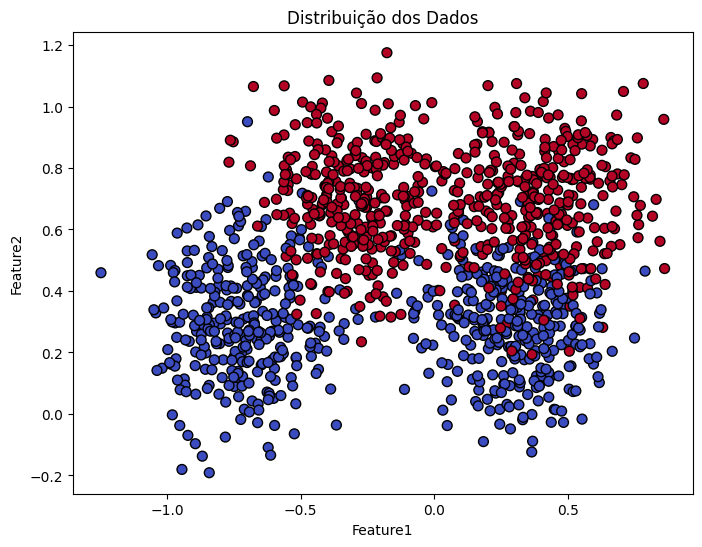

In [176]:
df_ripley = pd.DataFrame(ripley_data['data'], columns=['Feature1', 'Feature2'])
df_ripley['Target'] = ripley_data['target']

plt.figure(figsize=(8, 6))
plt.scatter(df_ripley['Feature1'], df_ripley['Feature2'], c=df_ripley['Target'], cmap='coolwarm', edgecolor='k', s=50)
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Distribuição dos Dados')
plt.show()

**MONTAGEM DO DATAFRAME - BANANA**

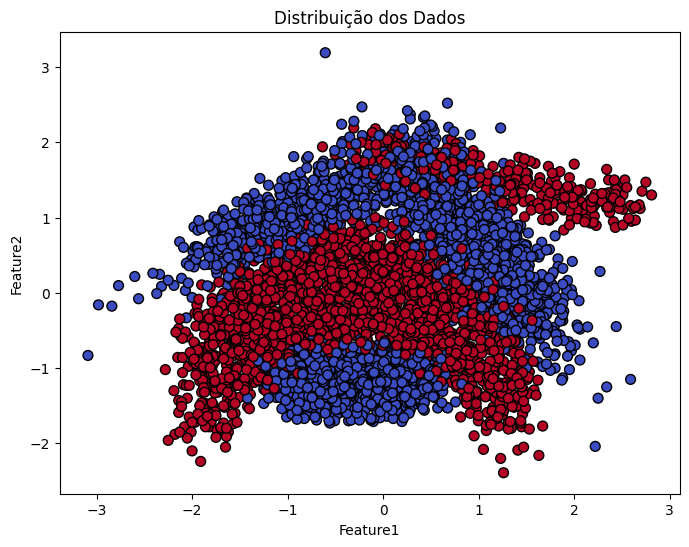

In [177]:
df_banana = pd.DataFrame(banana_data['data'], columns=['Feature1', 'Feature2'])
df_banana['Target'] = banana_data['target']

plt.figure(figsize=(8, 6))
plt.scatter(df_banana['Feature1'], df_banana['Feature2'], c=df_banana['Target'], cmap='coolwarm', edgecolor='k', s=50)
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Distribuição dos Dados')
plt.show()

**MONTAGEM DO DATAFRAME - TWO_MOON**

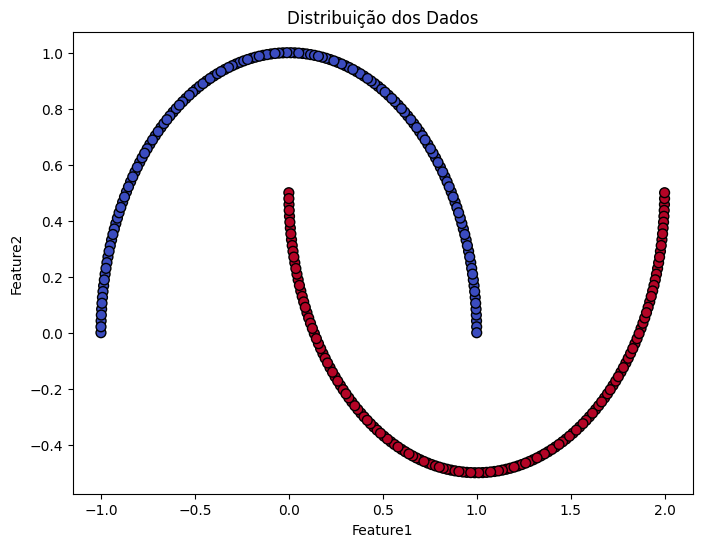

In [178]:
df_two_moon = pd.DataFrame(two_moon_data['data'], columns=['Feature1', 'Feature2'])
df_two_moon['Target'] = two_moon_data['target']

plt.figure(figsize=(8, 6))
plt.scatter(df_two_moon['Feature1'], df_two_moon['Feature2'], c=df_two_moon['Target'], cmap='coolwarm', edgecolor='k', s=50)
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.title('Distribuição dos Dados')
plt.show()

**REALIZANDO A DIVISÃO ENTRE X E Y - RIPLEY**

In [179]:
X_ripley = df_ripley[['Feature1', 'Feature2']]
Y_ripley = df_ripley['Target']

**DIVISÃO DE TREINO HOLD-OUT - RIPLEY**

In [180]:
X_train_ripley, X_test_ripley, Y_train_ripley, Y_test_ripley = train_test_split(X_ripley, Y_ripley, test_size = 0.2, random_state=2)

**REALIZANDO O TREINAMENTO DA REDE MLP - RIPLEY**

In [181]:
qtd_input_neurons = 2;
qtd_hidden_layer = 8;
qtd_output_neurons = 2;

mlp = MLP(qtd_input_neurons, qtd_hidden_layer, qtd_output_neurons)

mlp.train(X_train_ripley, Y_train_ripley, epochs=100, learning_rate=0.001)


Época 0, 
Loss: 1076.0565217427074, 
Acurácia: 52.552552552552555, 
Precisão: 52.38938053097345, 
Recall: 59.08183632734531, 
F1-Score: 55.534709193245774


Época 10, 
Loss: 405.88611075952144, 
Acurácia: 89.1891891891892, 
Precisão: 88.60510805500982, 
Recall: 90.01996007984032, 
F1-Score: 89.3069306930693


Época 20, 
Loss: 347.1520941385227, 
Acurácia: 88.88888888888889, 
Precisão: 88.23529411764706, 
Recall: 89.82035928143712, 
F1-Score: 89.02077151335311


Época 30, 
Loss: 321.69190154378646, 
Acurácia: 88.68868868868869, 
Precisão: 88.0392156862745, 
Recall: 89.62075848303394, 
F1-Score: 88.82294757665677


Época 40, 
Loss: 307.12011827913284, 
Acurácia: 88.38838838838838, 
Precisão: 87.81925343811395, 
Recall: 89.22155688622755, 
F1-Score: 88.51485148514851


Época 50, 
Loss: 297.61170115629193, 
Acurácia: 88.38838838838838, 
Precisão: 87.67123287671232, 
Recall: 89.42115768463074, 
F1-Score: 88.53754940711462


Época 60, 
Loss: 290.8944210746025, 
Acurácia: 88.38838838838838, 

**SUPERFÍCIE DE DECISÃO - RIPLEY**

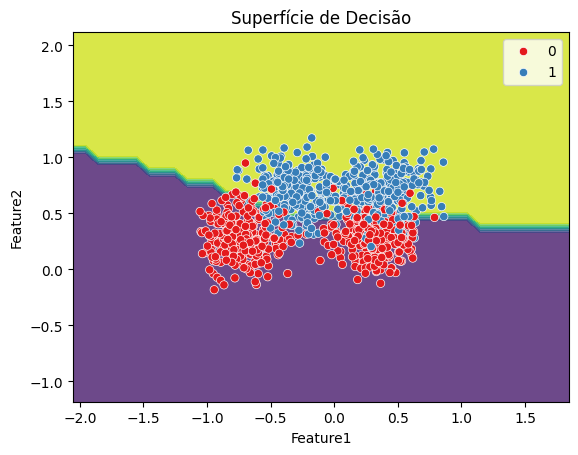

In [182]:
mlp.plot_decision_boundary(X_train_ripley.values, Y_train_ripley.values)

**TESTE COM A REDE MLP - RIPLEY**

Acurácia: 91.60000000000001, 
Precisão: 89.84375, 
Recall: 93.4959349593496, 
F1-Score: 91.63346613545818, 
AUC: 0.9743294283336534


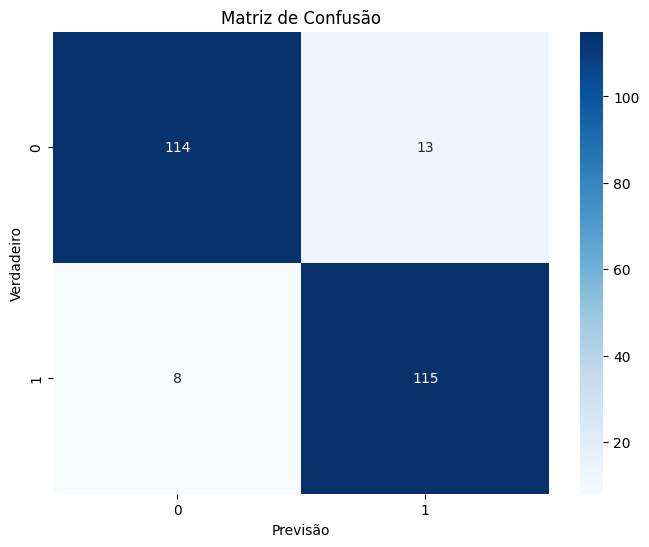

In [183]:
y_pred_ripley = mlp.evaluate(X_test_ripley, Y_test_ripley)

**SUPERFÍCIE DE DECISÃO DOS DADOS DE TESTE**

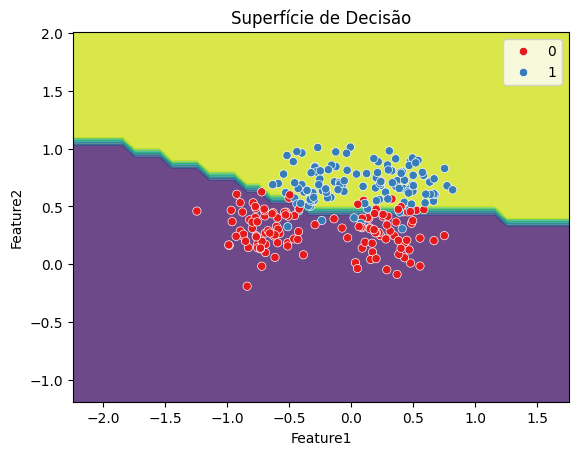

In [184]:
mlp.plot_decision_boundary(X_test_ripley.values, Y_test_ripley.values)

**REALIZANDO DIVISÃO ENTRE X E Y - BANANA**

In [185]:
X_banana = df_banana[['Feature1', 'Feature2']]
Y_banana = df_banana['Target']

**DIVISÃO DE TREINO HOLD-OUT - BANANA**

In [213]:
X_train_banana, X_test_banana, Y_train_banana, Y_test_banana = train_test_split(X_banana, Y_banana, test_size = 0.2, random_state=2)

**REALIZANDO O TREINAMENTO DA REDE MLP - BANANA**

In [220]:
qtd_hidden_layer_adapt_to_banana_dataframe = 56;

mlp = MLP(qtd_input_neurons, qtd_hidden_layer_adapt_to_banana_dataframe, qtd_output_neurons)

oversample = SMOTE()
X_train_banana, Y_train_banana = oversample.fit_resample(X_train_banana, Y_train_banana)

mlp.train(X_train_banana, Y_train_banana, epochs=1000, learning_rate=0.001)


Época 0, 
Loss: 15039.4927655783, 
Acurácia: 45.963263562580096, 
Precisão: 45.80559254327563, 
Recall: 44.08372490388723, 
F1-Score: 44.928167174575535


Época 10, 
Loss: 10401.720531934237, 
Acurácia: 56.19393421614694, 
Precisão: 54.69255663430421, 
Recall: 72.19137120888509, 
F1-Score: 62.23531577978273


Época 20, 
Loss: 6163.0481694699665, 
Acurácia: 63.477146518581804, 
Precisão: 60.1219120949631, 
Recall: 80.05126014523708, 
F1-Score: 68.66984243312568


Época 30, 
Loss: 3908.4530047238873, 
Acurácia: 72.72533105510466, 
Precisão: 70.2127659574468, 
Recall: 78.94062366510039, 
F1-Score: 74.32133521013472


Época 40, 
Loss: 3160.324206799966, 
Acurácia: 77.74455360956856, 
Precisão: 73.8348623853211, 
Recall: 85.94617684750106, 
F1-Score: 79.43150414528228


Época 50, 
Loss: 3702.231075429506, 
Acurácia: 71.76420333190944, 
Precisão: 68.32074793239842, 
Recall: 81.16189662537377, 
F1-Score: 74.18976962124171


Época 60, 
Loss: 3529.736810183414, 
Acurácia: 77.701836821871, 
Pre

**SUPERFÍCIE DE DECISÃO DOS DADOS DE TREINO - BANANA**

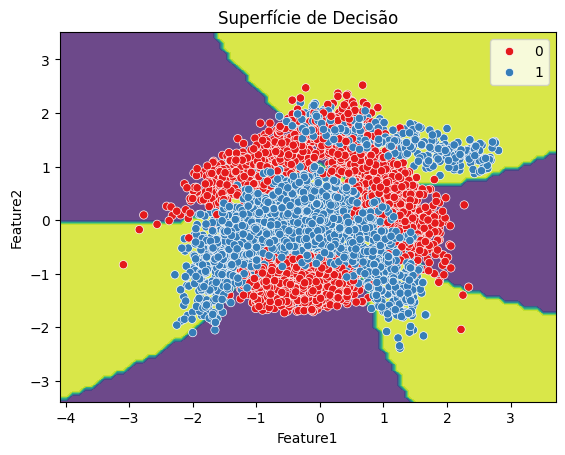

In [221]:
mlp.plot_decision_boundary(X_train_banana.values, Y_train_banana.values)

**TESTE COM A REDE MLP - BANANA**

Acurácia: 86.79245283018868, 
Precisão: 81.26159554730982, 
Recall: 91.82389937106919, 
F1-Score: 86.22047244094487, 
AUC: 0.9515284565124364


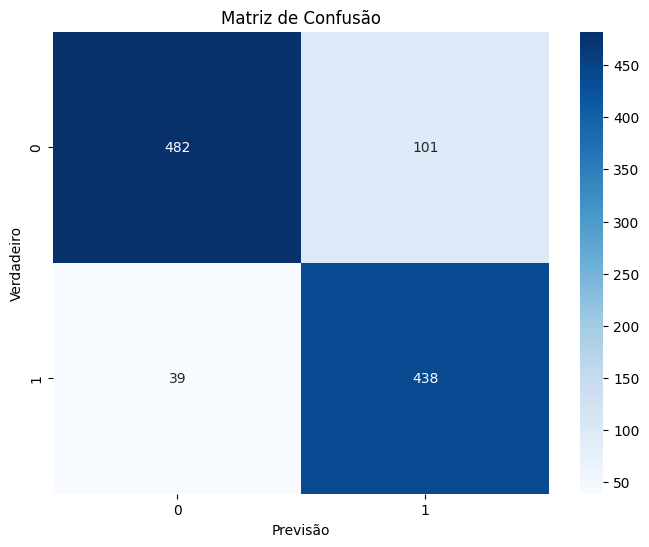

In [222]:
y_pred_banana = mlp.evaluate(X_test_banana, Y_test_banana)

**SUPERFÍCIE DE DECISÃO DOS DADOS DE TESTE - BANANA**

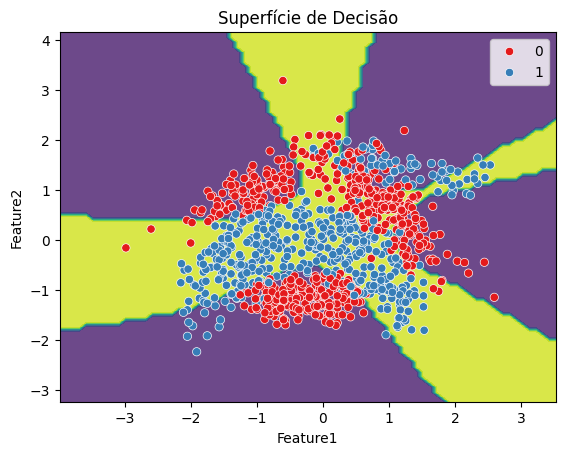

In [190]:
mlp.plot_decision_boundary(X_test_banana.values, Y_test_banana.values)

**REALIZANDO A DIVISÃO ENTRE X E Y - TWO MOON**

In [191]:
X_two_moon = df_two_moon[['Feature1', 'Feature2']]
Y_two_moon = df_two_moon['Target']

**DIVISÃO DE TREINO HOLD-OUT - TWO MOON**

In [197]:
X_train_two_moon, X_test_two_moon, Y_train_two_moon, Y_test_two_moon = train_test_split(X_two_moon, Y_two_moon, test_size = 0.2, random_state=2)

**REALIZANDO O TREINAMENTO DA REDE MLP - TWO MOON**

In [210]:
qtd_hidden_layer_adapt_to_two_moon_dataframe = 64;

mlp = MLP(qtd_input_neurons, qtd_hidden_layer_adapt_to_two_moon_dataframe, qtd_output_neurons)

oversample = SMOTE()
X_train_two_moon, Y_train_two_moon = oversample.fit_resample(X_train_two_moon, Y_train_two_moon)

mlp.train(X_train_two_moon, Y_train_two_moon, epochs=1000, learning_rate=0.001)


Época 0, 
Loss: 299.36251165869214, 
Acurácia: 79.50819672131148, 
Precisão: 74.65753424657534, 
Recall: 89.34426229508196, 
F1-Score: 81.34328358208954


Época 10, 
Loss: 263.705337821384, 
Acurácia: 80.73770491803278, 
Precisão: 76.59574468085107, 
Recall: 88.52459016393442, 
F1-Score: 82.12927756653993


Época 20, 
Loss: 224.55960754716716, 
Acurácia: 82.37704918032787, 
Precisão: 78.83211678832117, 
Recall: 88.52459016393442, 
F1-Score: 83.3976833976834


Época 30, 
Loss: 190.8878845050107, 
Acurácia: 84.42622950819673, 
Precisão: 82.3076923076923, 
Recall: 87.70491803278688, 
F1-Score: 84.92063492063492


Época 40, 
Loss: 168.34609761812362, 
Acurácia: 85.65573770491804, 
Precisão: 84.8, 
Recall: 86.88524590163934, 
F1-Score: 85.82995951417003


Época 50, 
Loss: 151.09737535421172, 
Acurácia: 86.47540983606558, 
Precisão: 86.1788617886179, 
Recall: 86.88524590163934, 
F1-Score: 86.53061224489797


Época 60, 
Loss: 137.67278355650822, 
Acurácia: 87.29508196721312, 
Precisão: 88.23

**SUPERFÍCIE DE DECISÃO DOS DADOS DE TREINO - TWO MOON**

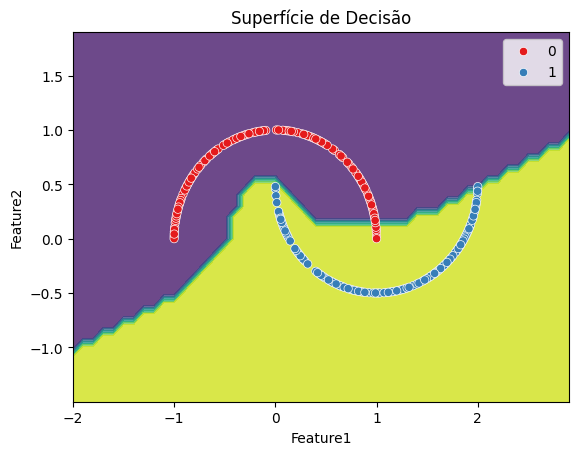

In [211]:
mlp.plot_decision_boundary(X_train_two_moon.values, Y_train_two_moon.values)

**TESTE COM A REDE MLP - TWO MOON**

Acurácia: 95.0, 
Precisão: 93.93939393939394, 
Recall: 96.875, 
F1-Score: 95.38461538461539, 
AUC: 0.9866071428571429


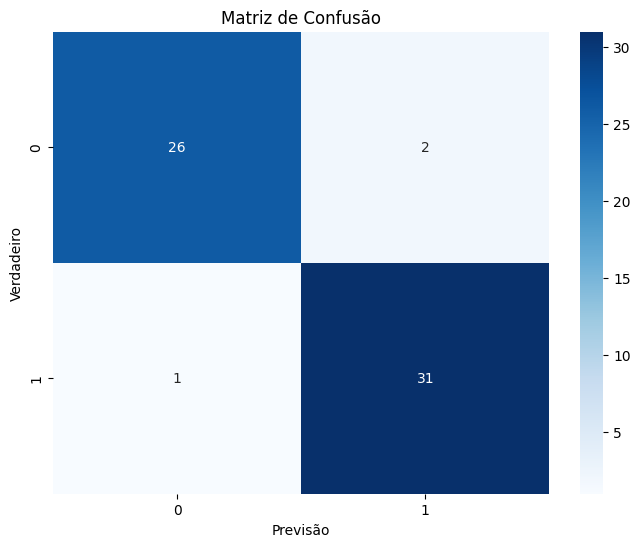

In [212]:
y_pred_two_moon = mlp.evaluate(X_test_two_moon, Y_test_two_moon)

**SUPERFÍCIE DE DECISÃO DOS DADOS DE TESTE - TWO MOON**

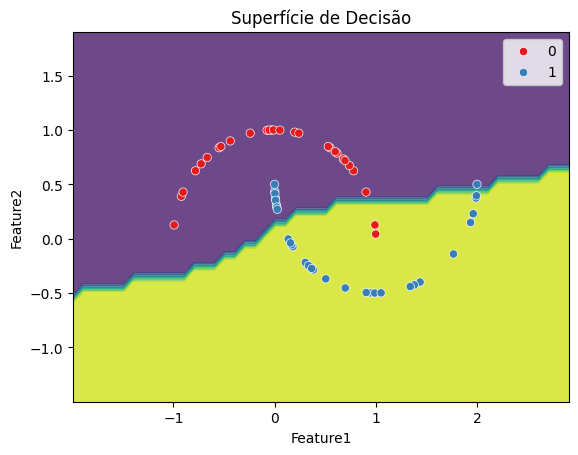

In [209]:
mlp.plot_decision_boundary(X_test_two_moon.values, Y_test_two_moon.values)